Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


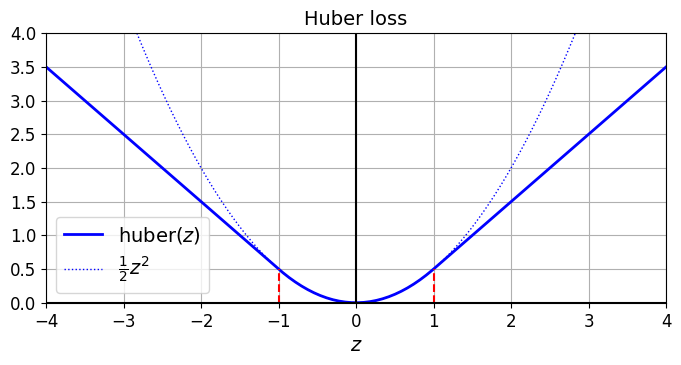

Epoch 1/2
363/363 [==============================] - 5s 6ms/step - loss: 0.5941 - mae: 0.9516 - val_loss: 0.2664 - val_mae: 0.5606
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2167 - mae: 0.5117 - val_loss: 0.2273 - val_mae: 0.5164
Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2022 - mae: 0.4928 - val_loss: 0.1895 - val_mae: 0.4718
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1958 - mae: 0.4840 - val_loss: 0.2059 - val_mae: 0.4899


In [ ]:
import sklearn
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#캘리포니아 주택 데이터셋
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

#후버 손실 직접 구현
def huber_fn(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < 1
  squared_loss = tf.square(error) / 2
  linear_loss = tf.abs(error) - 0.5
  return tf.where(is_small_error, squared_loss, linear_loss)
  #is_small_error (f(x) < 1 이라면 squared한 2차 함수, else f(x)-5 의 1차함수)

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

input_shape = X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
#model compile 과정에서 loss = huber_fn 으로 사용가능
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.save("my_model_with_a_custom_loss.h5")

model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

def create_huber(threshold=1.0):        #create_huber >> 임계값 지정가능
  def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < threshold
    squared_loss = tf.square(error) / 2
    linear_loss = threshold * tf.abs(error) - threshold**2 / 2
    return tf.where(is_small_error, squared_loss, linear_loss)
  return huber_fn

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.save("my_model_with_a_custom_loss_threshold_2.h5")
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

#threshold 값을 모델에 같이 저장하지 못하므로 load할때 같이 지정해줘야함

class HuberLoss(keras.losses.Loss):
  def __init__(self, threshold=1.0, **kwargs):
    self.threshold = threshold
    super().__init__(**kwargs)
  def call(self, y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < self.threshold
    squared_loss = tf.square(error) / 2
    linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
    return tf.where(is_small_error, squared_loss, linear_loss)
  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "threshold": self.threshold}

#super()로 부모클래스(keras.losses.Loss)에서 method를 가져와서 사용

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def my_softplus(z):
  return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
  stddev = tf.sqrt(2. / (shape[0] + shape[1]))
  return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
  return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
  return tf.where(weights < 0., tf.zeros_like(weights), weights)

layer = keras.layers.Dense(30, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)











